In [1]:
import os
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize, to_pil_image
import matplotlib.pyplot as plt
import json
import math

parent_dir = os.path.abspath(os.path.pardir)
sys.path.append(parent_dir)

import datasets
from models import get_model
from utils import resize_density_map, sliding_window_predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


truncation = 4
reduction = 8
granularity = "fine"
anchor_points = "average"

model_name = "clip_vit_b_16"
input_size = 224
window_size = 224
stride = 224 #Usado con sliding window (PARECE FUNCIONAR MUCHO MEJOR EN LAS PREDICCIONES [mirar texto negro sobre las imagenes])
#stride=None 
weight_count_loss = 1.0
count_loss = "dmcount"

# Comment the lines below to test non-CLIP models.
prompt_type = "word"
num_vpt = 32
vpt_drop = 0.
deep_vpt = True

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
alpha = 0.8

C:\Users\34628\Anaconda3\envs\CLIP\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [2]:
#CARGO LOS PUNTOS DE HINRICHS: 
#(Pruebo con Hinrichs primero que ya los conozco y se usarlos)
permutations = {2: (0, 1),
                3: (0, 1, 2),
                4: (0, 1, 3, 2),
                5: (0, 2, 4, 1, 3),
                6: (0, 2, 4, 1, 5, 3),
                7: (0, 2, 4, 6, 1, 3, 5),
                8: (0, 3, 6, 1, 4, 7, 2, 5),
                9: (0, 2, 6, 3, 8, 5, 1, 7, 4),
                10: (0, 3, 7, 1, 4, 9, 6, 2, 8, 5),
                11: (0, 3, 8, 1, 6, 10, 4, 7, 2, 9, 5),
                12: (0, 5, 10, 3, 8, 1, 6, 11, 4, 9, 2, 7),
                13: (0, 5, 10, 2, 7, 12, 4, 9, 1, 6, 11, 3, 8),
                14: (0, 5, 10, 2, 8, 13, 4, 11, 6, 1, 9, 3, 12, 7),
                15: (0, 4, 9, 13, 6, 1, 11, 3, 8, 14, 5, 10, 2, 12, 7),
                16: (0, 3, 11, 5, 14, 9, 1, 7, 12, 4, 15, 10, 2, 6, 13, 8),
                }

hinrichs = dict()
for i in range(2, 17):
    temp = []
    for j, k in zip(range(i), permutations[i]):
        temp.append((j/i, k/i))
    hinrichs[i] = temp

In [7]:
hinrichs

{2: [(0.0, 0.0), (0.5, 0.5)],
 3: [(0.0, 0.0),
  (0.3333333333333333, 0.3333333333333333),
  (0.6666666666666666, 0.6666666666666666)],
 4: [(0.0, 0.0), (0.25, 0.25), (0.5, 0.75), (0.75, 0.5)],
 5: [(0.0, 0.0), (0.2, 0.4), (0.4, 0.8), (0.6, 0.2), (0.8, 0.6)],
 6: [(0.0, 0.0),
  (0.16666666666666666, 0.3333333333333333),
  (0.3333333333333333, 0.6666666666666666),
  (0.5, 0.16666666666666666),
  (0.6666666666666666, 0.8333333333333334),
  (0.8333333333333334, 0.5)],
 7: [(0.0, 0.0),
  (0.14285714285714285, 0.2857142857142857),
  (0.2857142857142857, 0.5714285714285714),
  (0.42857142857142855, 0.8571428571428571),
  (0.5714285714285714, 0.14285714285714285),
  (0.7142857142857143, 0.42857142857142855),
  (0.8571428571428571, 0.7142857142857143)],
 8: [(0.0, 0.0),
  (0.125, 0.375),
  (0.25, 0.75),
  (0.375, 0.125),
  (0.5, 0.5),
  (0.625, 0.875),
  (0.75, 0.25),
  (0.875, 0.625)],
 9: [(0.0, 0.0),
  (0.1111111111111111, 0.2222222222222222),
  (0.2222222222222222, 0.6666666666666666),
  (

## Visualization on UCF-QNRF (with GT labels)

In [11]:
dataset_name = "qnrf" #select dataset name
split = "val"

if truncation is None:  # regression, no truncation.
    bins, anchor_points = None, None
else:
    with open(os.path.join(parent_dir, "configs", f"reduction_{reduction}.json"), "r") as f:
        config = json.load(f)[str(truncation)][dataset_name]
    bins = config["bins"][granularity]
    anchor_points = config["anchor_points"][granularity]["average"] if anchor_points == "average" else config["anchor_points"][granularity]["middle"]
    bins = [(float(b[0]), float(b[1])) for b in bins]
    anchor_points = [float(p) for p in anchor_points]

model = get_model(
    backbone=model_name,
    input_size=input_size, 
    reduction=reduction,
    bins=bins,
    anchor_points=anchor_points,
    # CLIP parameters
    prompt_type=prompt_type,
    num_vpt=num_vpt,
    vpt_drop=vpt_drop,
    deep_vpt=deep_vpt
)

#Change ckpt_dir_name to get the weights you want
#ckpt_dir_name = f"{model_name}_{prompt_type}_" if "clip" in model_name else f"{model_name}_"
#ckpt_dir_name += f"{input_size}_{reduction}_{truncation}_{granularity}_"
#ckpt_dir_name += f"{weight_count_loss}_{count_loss}"
ckpt_dir_name = 'UCF_QNRF_CLIP_EBC_ViT_B_16_Word'

ckpt_path = os.path.join(
    parent_dir,
    "checkpoints",
    ckpt_dir_name,
    "best_mae.pth"  # select the weight file that you want to test
)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt)
model = model.to(device)

Missing keys: []
Unexpected keys: ['proj']
All keys matched successfully.
Initialized model with text prompts: ['There is no person.', 'There is one person.', 'There are two people.', 'There are three people.', 'There are more than four people.']


In [12]:
dataset = datasets.Crowd(dataset=dataset_name, split=split, sigma=8, return_filename=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=datasets.collate_fn)
data_iter = iter(dataloader)

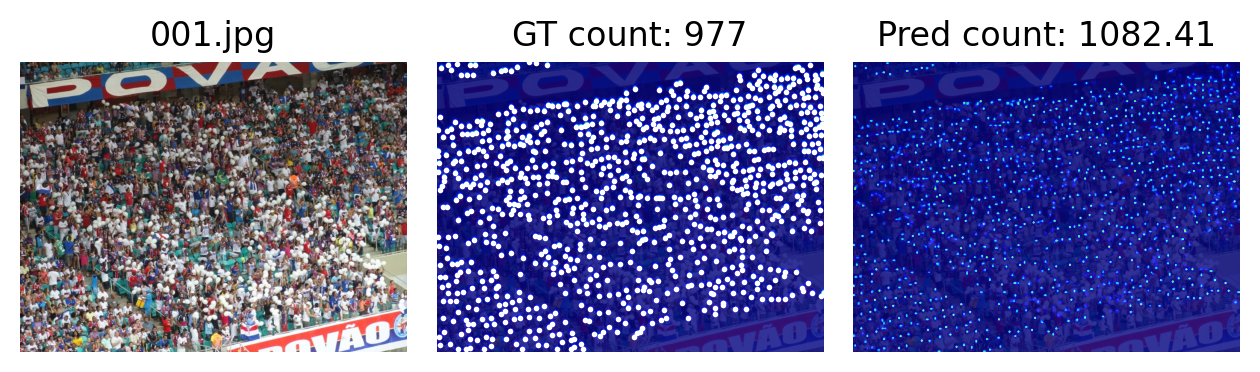

In [13]:
img_id = 0 #CODIGO ORIGINAL
model.eval()
if img_id is not None:
    image, points, density, image_path = dataset[img_id]
else:
    image, points, density, image_path = next(data_iter)

image_height, image_width = image.shape[-2:]
image = image.to(device)
image_name = os.path.basename(image_path[0])

with torch.no_grad():
    if stride is not None:  # Sliding window prediction.
        pred_density = sliding_window_predict(model, image, window_size, stride)
    else:
        pred_density = model(image)
    pred_count = pred_density.sum().item()
    resized_pred_density = resize_density_map(pred_density, (image_height, image_width)).cpu()

image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0)) #SE CONVIERTE A IMAGEN PIL AQUI

density = density.squeeze().numpy()
resized_pred_density = resized_pred_density.squeeze().numpy()
points = points[0].numpy()

fig, axes = plt.subplots(1, 3, dpi=200, tight_layout=True, frameon=False)
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title(f"{image_name}")

axes[1].imshow(image)
if len(points) > 0:
    axes[1].scatter(points[:, 0], points[:, 1], s=1, c="white")
    axes[1].imshow(density, cmap="jet", alpha=alpha)
axes[1].axis("off")
axes[1].set_title(f"GT count: {len(points)}")

axes[2].imshow(image)
axes[2].imshow(resized_pred_density, cmap="jet", alpha=alpha)
axes[2].axis("off")
axes[2].set_title(f"Pred count: {pred_count:.2f}")

plt.show()
# fig.savefig(f"output/{image_name}", transparent=True, bbox_inches="tight", pad_inches=0)

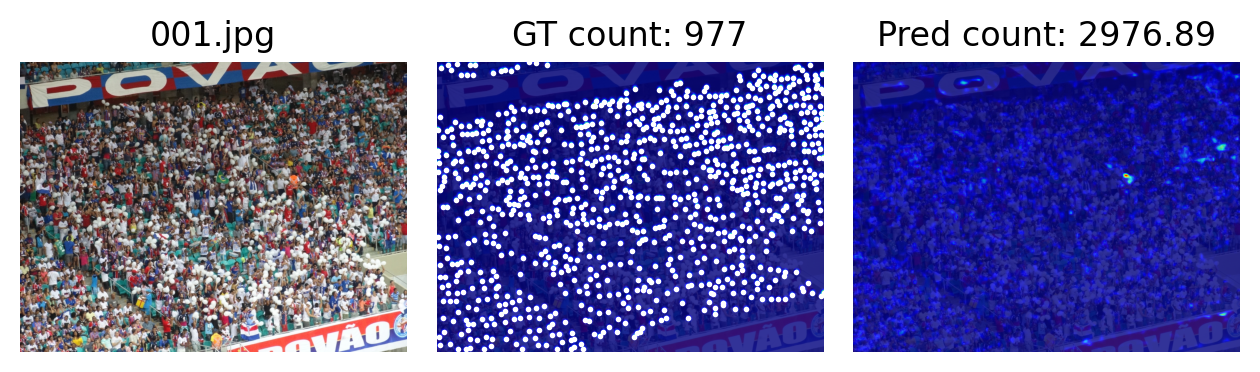

In [19]:
img_id = 0 #CODIGO ORIGINAL CON stride=None
model.eval()
if img_id is not None:
    image, points, density, image_path = dataset[img_id]
else:
    image, points, density, image_path = next(data_iter) 

image_height, image_width = image.shape[-2:]
image = image.to(device)
image_name = os.path.basename(image_path[0])

with torch.no_grad():
    if stride is not None:  # Sliding window prediction.
        pred_density = sliding_window_predict(model, image, window_size, stride)
    else:
        pred_density = model(image)
    pred_count = pred_density.sum().item()
    resized_pred_density = resize_density_map(pred_density, (image_height, image_width)).cpu()

image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0))

density = density.squeeze().numpy()
resized_pred_density = resized_pred_density.squeeze().numpy()
points = points[0].numpy()

fig, axes = plt.subplots(1, 3, dpi=200, tight_layout=True, frameon=False)
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title(f"{image_name}")

axes[1].imshow(image)
if len(points) > 0:
    axes[1].scatter(points[:, 0], points[:, 1], s=1, c="white")
    axes[1].imshow(density, cmap="jet", alpha=alpha)
axes[1].axis("off")
axes[1].set_title(f"GT count: {len(points)}")

axes[2].imshow(image)
axes[2].imshow(resized_pred_density, cmap="jet", alpha=alpha)
axes[2].axis("off")
axes[2].set_title(f"Pred count: {pred_count:.2f}")

plt.show()
# fig.savefig(f"output/{image_name}", transparent=True, bbox_inches="tight", pad_inches=0)

# PRUEBA RECORTE

In [96]:
image.shape

torch.Size([1, 3, 1536, 2048])

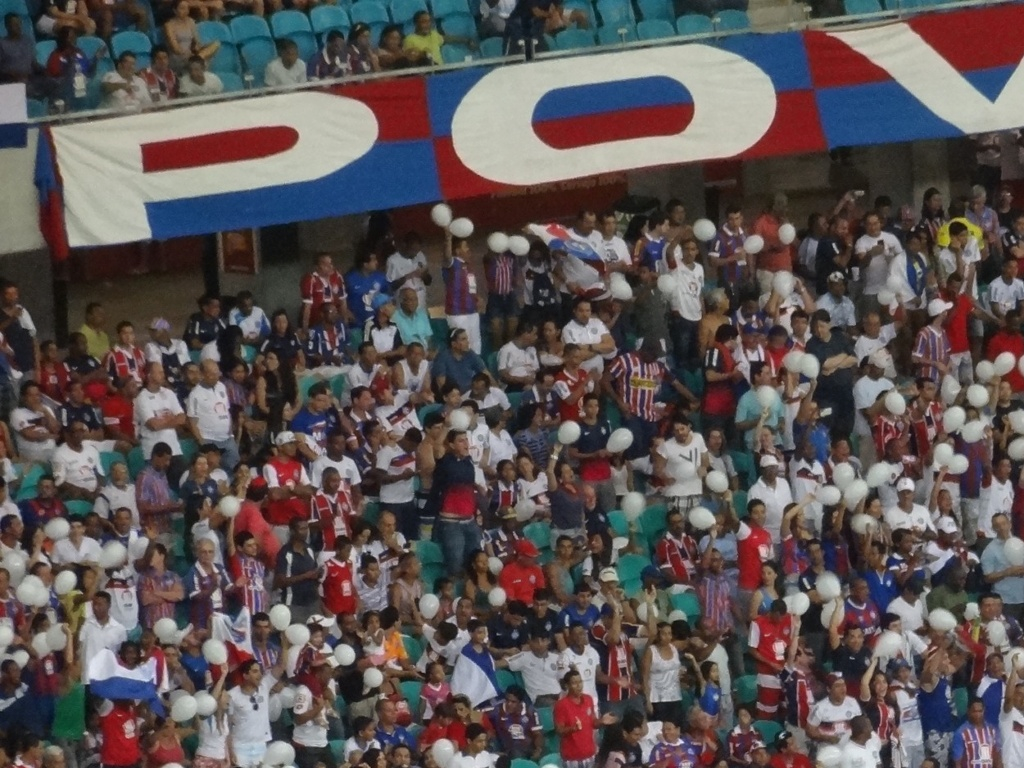

In [107]:
#CARGO IMAGEN
img_id = 0
model.eval()
if img_id is not None:
    image, points, density, image_path = dataset[img_id]
else:
    image, points, density, image_path = next(data_iter) 

image_height, image_width = image.shape[-2:]

#RECORTO IMAGEN
N = 2
pointset = hinrichs[N]

#Aqui deberia hacer bucle para cada punto...
i=0
point = pointset[i]
left = math.floor(point[0]*image_width)
right = math.floor((point[0]+1/N)*image_width)
bottom = math.floor(point[1]*image_height)
top = math.floor((point[1]+1/N)*image_height)

#Recorto la imagen tq la esquina inferior izquierda del recorte es el punto óptimo del pointset
image = image[:,:,bottom:top,left:right] #OBS: Tamaño del recorte = máximo tq el recorte no se sobrepone a los demás ni se sale del tamaño
#OBS: No me coge lo que quiero porque el tensor empieza desde la esquina superior izquerda de la imagen.............

#ENSEÑO IMAGEN
image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
to_pil_image(image.squeeze(0))

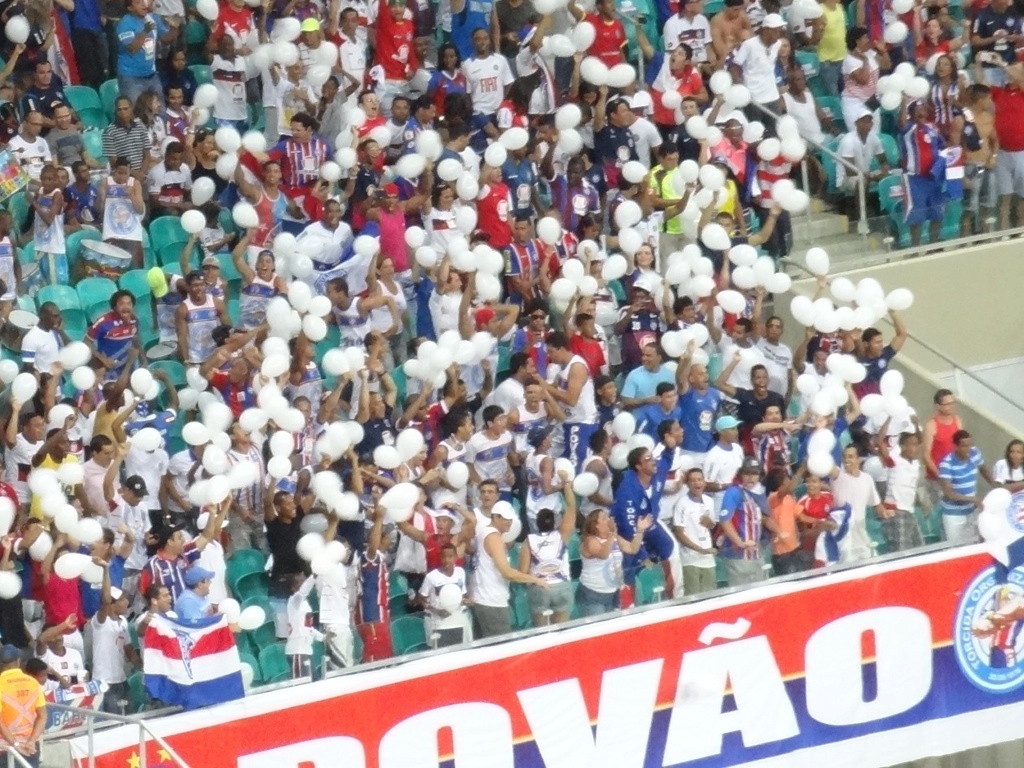

In [108]:
#CARGO IMAGEN
img_id = 0
model.eval()
if img_id is not None:
    image, points, density, image_path = dataset[img_id]
else:
    image, points, density, image_path = next(data_iter) 

image_height, image_width = image.shape[-2:]

#RECORTO IMAGEN
N = 2
pointset = hinrichs[N]

#Aqui deberia hacer bucle para cada punto...
i=1
point = pointset[i]
left = math.floor(point[0]*image_width)
right = math.floor((point[0]+1/N)*image_width)
bottom = math.floor(point[1]*image_height)
top = math.floor((point[1]+1/N)*image_height)

#Recorto la imagen tq la esquina inferior izquierda del recorte es el punto óptimo del pointset
image = image[:,:,bottom:top,left:right] #OBS: Tamaño del recorte = máximo tq el recorte no se sobrepone a los demás ni se sale del tamaño
#OBS: No me coge lo que quiero porque el tensor empieza desde la esquina superior izquerda de la imagen.............

#ENSEÑO IMAGEN
image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
to_pil_image(image.squeeze(0))

# RECORTE

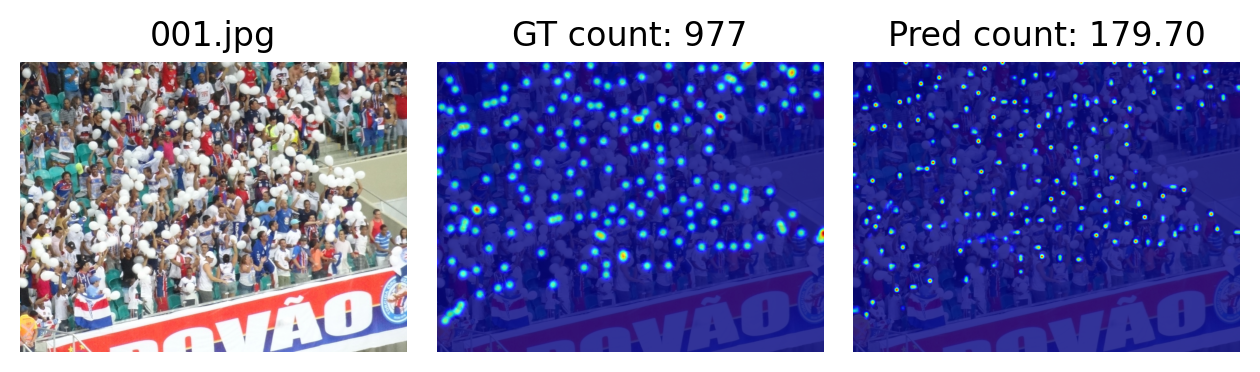

In [121]:
img_id = 0 #CODIGO PARA VER QUE EL RECORTE LE HAGO BIEN
model.eval()
if img_id is not None:
    image, points, density, image_path = dataset[img_id]
else:
    image, points, density, image_path = next(data_iter) 

original_image = image
image_height, image_width = image.shape[-2:]
#image = image.to(device)
image_name = os.path.basename(image_path[0])

#Recortar la imagen antes de evaluar el modelo (NO SE SI EL STRIDE IMPORTA O NO POR LA SLIDING WINDOW)
N = 2 #NUMBER OF POINTS TO CONSIDER IN THE OPTIMAL POINT SET (tendre que hacer un bucle sobre range(N) para predecir modelo en cada recorte)
pointset = hinrichs[N]

#Aqui deberia hacer bucle para cada punto...
i=1
point = pointset[i]
left = math.floor(point[0]*image_width)
right = math.floor((point[0]+1/N)*image_width)
bottom = math.floor(point[1]*image_height)
top = math.floor((point[1]+1/N)*image_height)
#Recorto la imagen tq la """"""""esquina inferior izquierda"""""""""" del recorte es el punto óptimo del pointset
image = image[:,:,bottom:top,left:right] #OBS: Tamaño del recorte = máximo tq el recorte no se sobrepone a los demás ni se sale del tamaño
new_image_height, new_image_width = image.shape[-2:]
image = image.to(device)

with torch.no_grad():
    if stride is not None:  # Sliding window prediction.
        pred_density = sliding_window_predict(model, image, window_size, stride)
    else:
        pred_density = model(image)
    pred_count = pred_density.sum().item()
    resized_pred_density = resize_density_map(pred_density, (new_image_height, new_image_width)).cpu()

image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0))

original_image = normalize(original_image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
original_image = normalize(original_image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
original_image = to_pil_image(original_image.squeeze(0))

density = density.squeeze().numpy()
resized_pred_density = resized_pred_density.squeeze().numpy()
points = points[0].numpy()

fig, axes = plt.subplots(1, 3, dpi=200, tight_layout=True, frameon=False)
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title(f"{image_name}")

#axes[1].imshow(original_image)
axes[1].imshow(image)
if len(points) > 0:
    #axes[1].scatter(points[:, 0], points[:, 1], s=1, c="white")
    #axes[1].imshow(density, cmap="jet", alpha=alpha)
    axes[1].imshow(density[bottom:top,left:right], cmap="jet", alpha=alpha)
axes[1].axis("off")
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=0, hspace=0)
axes[1].set_title(f"GT count: ??")#{len(points)}") #PUEDO MOSTRAR LA TOTAL PERO ESO SERIA PARA CUANDO YA CALCULE LA PREDICCION TOTAL

axes[2].imshow(image)
axes[2].imshow(resized_pred_density, cmap="jet", alpha=alpha)
axes[2].axis("off")
axes[2].set_title(f"Pred count: {pred_count:.2f}")

plt.show()
# fig.savefig(f"output/{image_name}", transparent=True, bbox_inches="tight", pad_inches=0)

## Visualization on NWPU-Test (without GT labels)

In [3]:
if truncation is None:  # regression, no truncation.
    bins, anchor_points = None, None
else:
    with open(os.path.join(parent_dir, "configs", f"reduction_{reduction}.json"), "r") as f:
        config = json.load(f)[str(truncation)]["nwpu"]
    bins = config["bins"][granularity]
    anchor_points = config["anchor_points"][granularity]["average"] if anchor_points == "average" else config["anchor_points"][granularity]["middle"]
    bins = [(float(b[0]), float(b[1])) for b in bins]
    anchor_points = [float(p) for p in anchor_points]


model = get_model(
    backbone=model_name,
    input_size=input_size, 
    reduction=reduction,
    bins=bins,
    anchor_points=anchor_points,
    # CLIP parameters
    prompt_type=prompt_type,
    num_vpt=num_vpt,
    vpt_drop=vpt_drop,
    deep_vpt=deep_vpt
)


#Change ckpt_dir_name to get the weights you want
#ckpt_dir_name = f"{model_name}_{prompt_type}_" if "clip" in model_name else f"{model_name}_"
#ckpt_dir_name += f"{input_size}_{reduction}_{truncation}_{granularity}_"
#ckpt_dir_name += f"{weight_count_loss}_{count_loss}"
ckpt_dir_name = 'NWPU_CLIP_ViT_B_16_Word'

ckpt_path = os.path.join(
    parent_dir,
    "checkpoints",
    ckpt_dir_name,
    "best_mae.pth"  # select the weight file that you want to test
)

#ckpt_dir_name = f"{model_name}_{prompt_type}_" if "clip" in model_name else f"{model_name}_"
#ckpt_dir_name += f"{input_size}_{reduction}_{truncation}_{granularity}_"
#ckpt_dir_name += f"{weight_count_loss}_{count_loss}"

#ckpt_path = os.path.join(
#    parent_dir,
#    "checkpoints",
#    "nwpu",
#    ckpt_dir_name,
#    "best_mae_0.pth"  # select the weight file that you want to test
#)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt)
model = model.to(device)
model.eval()

dataset = datasets.NWPUTest(transforms=None, return_filename=True)

Missing keys: []
Unexpected keys: ['proj']
All keys matched successfully.
Initialized model with text prompts: ['There is no person.', 'There is one person.', 'There are two people.', 'There are three people.', 'There are more than four people.']


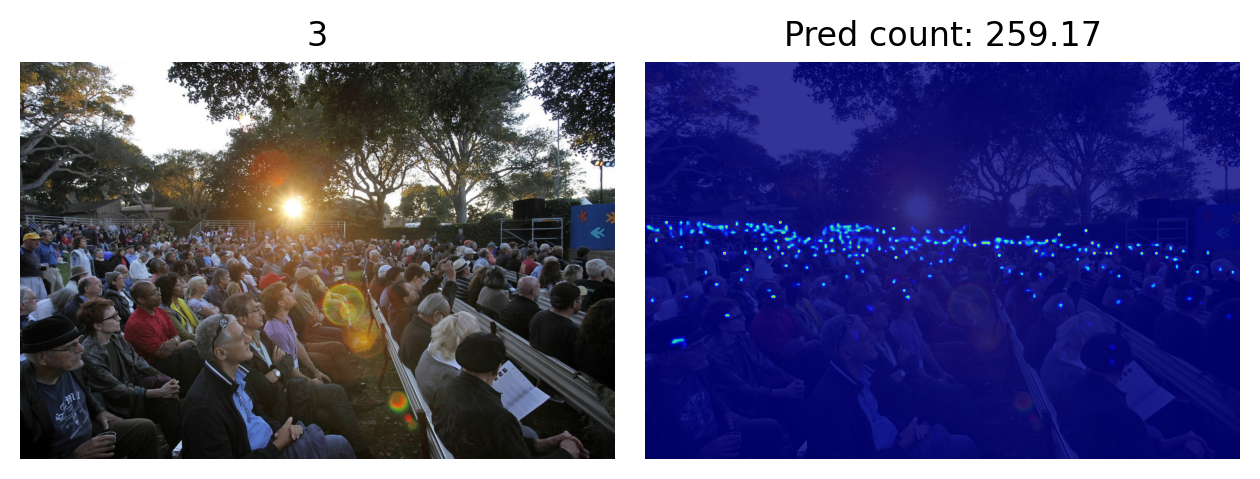

In [125]:
img_id = 0 #CODIGO ORIGINAL
image, image_path = dataset[img_id] 

image = image.unsqueeze(0)

image_height, image_width = image.shape[-2:]
image = image.to(device)
image_name = os.path.basename(image_path[0])

with torch.no_grad():
    if stride is not None:  # Sliding window prediction.
        pred_density = sliding_window_predict(model, image, window_size, stride)
    else:
        pred_density = model(image)
    pred_count = pred_density.sum().item()
    resized_pred_density = resize_density_map(pred_density, (image_height, image_width)).cpu()

image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0)) #SE CONVIERTE A IMAGEN PIL AQUI

resized_pred_density = resized_pred_density.squeeze().numpy()

fig, axes = plt.subplots(1, 2, dpi=200, tight_layout=True, frameon=False)
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title(f"{image_name}")

axes[1].imshow(image)
axes[1].imshow(resized_pred_density, cmap="jet", alpha=alpha)
axes[1].axis("off")
axes[1].set_title(f"Pred count: {pred_count:.2f}")

plt.show()
# fig.savefig(f"output/{image_name}", transparen

# RECORTE

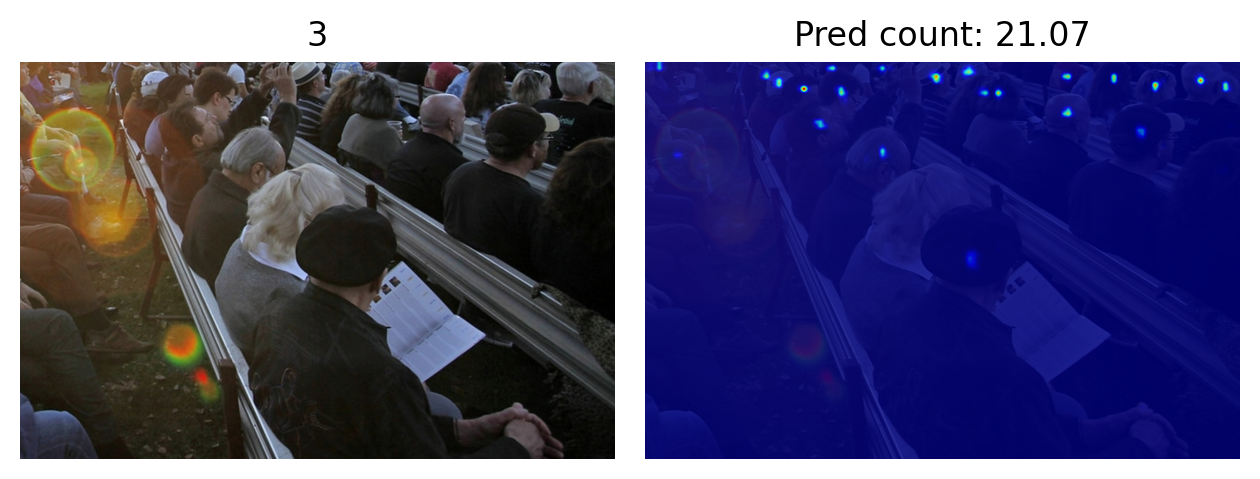

In [126]:
img_id = 0 #CODIGO PARA VER QUE EL RECORTE LE HAGO BIEN
image, image_path = dataset[img_id] 

image = image.unsqueeze(0)

image_height, image_width = image.shape[-2:]
#image = image.to(device)
image_name = os.path.basename(image_path[0])

#Recortar la imagen antes de evaluar el modelo (NO SE SI EL STRIDE IMPORTA O NO POR LA SLIDING WINDOW)
N = 2 #NUMBER OF POINTS TO CONSIDER IN THE OPTIMAL POINT SET (tendre que hacer un bucle sobre range(N) para predecir modelo en cada recorte)
pointset = hinrichs[N]

#Aqui deberia hacer bucle para cada punto...
i=1
point = pointset[i]
left = math.floor(point[0]*image_width)
right = math.floor((point[0]+1/N)*image_width)
bottom = math.floor(point[1]*image_height)
top = math.floor((point[1]+1/N)*image_height)
#Recorto la imagen tq la """"""""esquina inferior izquierda"""""""""" del recorte es el punto óptimo del pointset
image = image[:,:,bottom:top,left:right] #OBS: Tamaño del recorte = máximo tq el recorte no se sobrepone a los demás ni se sale del tamaño
new_image_height, new_image_width = image.shape[-2:]
image = image.to(device)

with torch.no_grad():
    if stride is not None:  # Sliding window prediction.
        pred_density = sliding_window_predict(model, image, window_size, stride)
    else:
        pred_density = model(image)
    pred_count = pred_density.sum().item()
    resized_pred_density = resize_density_map(pred_density, (new_image_height, new_image_width)).cpu()

image = normalize(image, mean=(0., 0., 0.), std=(1. / std[0], 1. / std[1], 1. / std[2]))
image = normalize(image, mean=(-mean[0], -mean[1], -mean[2]), std=(1., 1., 1.))
image = to_pil_image(image.squeeze(0))

resized_pred_density = resized_pred_density.squeeze().numpy()

fig, axes = plt.subplots(1, 2, dpi=200, tight_layout=True, frameon=False)
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title(f"{image_name}")

axes[1].imshow(image)
axes[1].imshow(resized_pred_density, cmap="jet", alpha=alpha)
axes[1].axis("off")
axes[1].set_title(f"Pred count: {pred_count:.2f}")

plt.show()
# fig.savefig(f"output/{image_name}", transparen